# Gensim

Authors: **Tasnima Sadekova**

Dr. Ilseyar Alimova

**Gensim** is billed as a Natural Language Processing package that does ‘Topic Modeling for Humans’. But it is practically much more than that. It is a leading and a state-of-the-art package for processing texts, working with *word vector models* and for building *topic models*.

But the width and scope of facilities to build and evaluate topic models are unparalleled in gensim, plus many more convenient facilities for text processing.

Also, another significant advantage with gensim is: it lets you handle large text files without having to load the entire file in memory.

In [91]:
from gensim import corpora
import gensim.downloader as api
from gensim.utils import simple_preprocess
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument, Doc2Vec

import pandas as pd
import nltk
import re
import gensim
import os
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings("ignore")

In [92]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anton\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Dictionary and Corpus

**Dictionary** is an object that maps each word to a unique id.

The dictionary object is typically used to create a ‘bag of words’ Corpus. It is this Dictionary and the bag-of-words (Corpus) that are used as inputs to topic modeling and other models that Gensim specializes in.

*gensim.utils.simple_preprocess* Convert a document into a list of lowercase tokens, ignoring tokens that are too short or too long.

In [93]:
# from a list of sentences

documents = ["If you use a car frequently, the first step to cutting",
             "down your emissions may well be to simply",
             "fully consider the",
             "alternatives available to you."
             ]

# Tokenize(split) the sentences into words
texts = [[text for text in doc.split()] for doc in documents]

# Create dictionary
dictionary = corpora.Dictionary(texts)

print(dictionary)
print(dictionary.token2id)

Dictionary<23 unique tokens: ['If', 'a', 'car', 'cutting', 'first']...>
{'If': 0, 'a': 1, 'car': 2, 'cutting': 3, 'first': 4, 'frequently,': 5, 'step': 6, 'the': 7, 'to': 8, 'use': 9, 'you': 10, 'be': 11, 'down': 12, 'emissions': 13, 'may': 14, 'simply': 15, 'well': 16, 'your': 17, 'consider': 18, 'fully': 19, 'alternatives': 20, 'available': 21, 'you.': 22}


With simple_preprocess

In [94]:
dictionary = corpora.Dictionary(simple_preprocess(line, deacc=True) for line in documents)  # deaccentuate
print(dictionary)
print(dictionary.token2id)

Dictionary<21 unique tokens: ['car', 'cutting', 'first', 'frequently', 'if']...>
{'car': 0, 'cutting': 1, 'first': 2, 'frequently': 3, 'if': 4, 'step': 5, 'the': 6, 'to': 7, 'use': 8, 'you': 9, 'be': 10, 'down': 11, 'emissions': 12, 'may': 13, 'simply': 14, 'well': 15, 'your': 16, 'consider': 17, 'fully': 18, 'alternatives': 19, 'available': 20}


Train your own word2vec model:

In [95]:
!pip install wget


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [96]:
import wget

wget.download('https://raw.githubusercontent.com/ancatmara/data-science-nlp/master/data/w2v/train/unlabeledTrainData.tsv')

'unlabeledTrainData (4).tsv'

In [97]:
data = pd.read_csv("unlabeledTrainData.tsv", header=0, delimiter="\t", quoting=3)

len(data)

50000

In [98]:
data.head()

,id,review
0,"""9999_0""","""Watching Time Chasers, it obvious that it was..."
1,"""45057_0""","""I saw this film about 20 years ago and rememb..."
2,"""15561_0""","""Minor Spoilers<br /><br />In New York, Joan B..."
3,"""7161_0""","""I went to see this film with a great deal of ..."
4,"""43971_0""","""Yes, I agree with everyone on this site this ..."


We remove links, html markup and non-alphabetic characters from the data, and then bring everything to lowercase and tokenize. The output is an array of sentences, each of which is an array of words. The tokenizer from the `nltk` library is used here.

In [99]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [100]:
from nltk.corpus import stopwords

nltk.download('stopwords')
stops = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anton\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [101]:
def review_to_wordlist(review, remove_stopwords=False):
    # remove links
    review = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", " ", review)
    # extract text
    review_text = BeautifulSoup(review, "html.parser").get_text()
    # only alphabetic characters
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    # lowercase + space symbol split
    words = review_text.lower().split()
    if remove_stopwords: # remove stopwords
        words = [w for w in words if not w in stops]
    return(words)

def review_to_sentences(review, tokenizer, remove_stopwords=False):
    # split into sentences
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    # apply cleaning to each sentence
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(review_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

In [102]:
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

sentences = []

print("Parsing sentences from training set...")
for review in data["review"]:
    sentences += review_to_sentences(review, tokenizer)

Parsing sentences from training set...


In [103]:
print(len(sentences))
print(sentences[0])

529416
['watching', 'time', 'chasers', 'it', 'obvious', 'that', 'it', 'was', 'made', 'by', 'a', 'bunch', 'of', 'friends']


Saving clean dataset:

In [104]:
!mkdir corpus

�������� ��� 䠩� corpus 㦥 �������.


In [105]:
with open('corpus/sample.txt', 'w') as f:
    for s in sentences[:5000]:
        f.write(' '.join(s))
        f.write('\n')

In [106]:
#from document
dictionary = corpora.Dictionary(simple_preprocess(line, deacc=True) for line in open('corpus/sample.txt', encoding='utf-8'))

In [107]:
len(dictionary)

11894

**Corpus** object that contains the word id and its frequency in each document.

The dictionary object is typically used to create a ‘bag of words’ Corpus. It is this Dictionary and the bag-of-words (Corpus) that are used as inputs to topic modeling and other models that Gensim specializes in.

- Bag of words

In [108]:
my_docs = ["Who let the dogs out?",
           "Who? Who? Who? Who?"]

# Tokenize the docs
tokenized_list = [simple_preprocess(doc) for doc in my_docs]

# Create the Corpus
dictionary = corpora.Dictionary()

#allow_update=True - add new words to dictionary
bow_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in tokenized_list]
print(bow_corpus)

print("Dictionary: ", dictionary.token2id)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)], [(4, 4)]]
Dictionary:  {'dogs': 0, 'let': 1, 'out': 2, 'the': 3, 'who': 4}


The (0, 1) in line 1 means, the word with id=0 appears once in the 1st document.
Likewise, the (4, 4) in the second list item means the word with id 4 appears 4 times in the second document. And so on.

- TfIdf in gensim

In [109]:
from gensim import models
import numpy as np

documents = ["This is the first line",
             "This is the second sentence",
             "This third document"]

# Create the Dictionary and Corpus
mydict = corpora.Dictionary([simple_preprocess(line) for line in documents])
corpus = [mydict.doc2bow(simple_preprocess(line)) for line in documents]

# Show the Word Weights in Corpus
for doc in corpus:
    print([[mydict[id], freq] for id, freq in doc])
print()

# Create the TF-IDF model
tfidf = models.TfidfModel(corpus, smartirs='ntc') # more on parameters here https://radimrehurek.com/gensim/models/tfidfmodel.html

# Show the TF-IDF weights
for doc in tfidf[corpus]:
    print([[mydict[id], np.around(freq, decimals=2)] for id, freq in doc])

[['first', 1], ['is', 1], ['line', 1], ['the', 1], ['this', 1]]
[['is', 1], ['the', 1], ['this', 1], ['second', 1], ['sentence', 1]]
[['this', 1], ['document', 1], ['third', 1]]

[['first', 0.63], ['is', 0.31], ['line', 0.63], ['the', 0.31], ['this', 0.13]]
[['is', 0.31], ['the', 0.31], ['this', 0.13], ['second', 0.63], ['sentence', 0.63]]
[['this', 0.15], ['document', 0.7], ['third', 0.7]]


Save and load

In [110]:
# Save the Dict and Corpus
dictionary.save('mydict.dict')  # save dict to disk
corpora.MmCorpus.serialize('bow_corpus.mm', bow_corpus)  # save corpus to disk

In [111]:
# Load them back
loaded_dict = corpora.Dictionary.load('mydict.dict')

corpus = corpora.MmCorpus('bow_corpus.mm')
for line in corpus:
    print(line)

[(0, 1.0), (1, 1.0), (2, 1.0), (3, 1.0), (4, 1.0)]
[(4, 4.0)]


## Datasets

Gensim provides an inbuilt API to download popular text datasets and word embedding models.

A comprehensive list of available datasets and models is maintained [here](https://raw.githubusercontent.com/RaRe-Technologies/gensim-data/master/list.json).

Using the API to download the dataset is as simple as calling the ```api.load()``` method with the right data or model name.

In [112]:
import gensim.downloader as api

In [113]:
# api.info('text8')
api.info('glove-wiki-gigaword-50')

{'num_records': 400000,
 'file_size': 69182535,
 'base_dataset': 'Wikipedia 2014 + Gigaword 5 (6B tokens, uncased)',
 'reader_code': 'https://github.com/RaRe-Technologies/gensim-data/releases/download/glove-wiki-gigaword-50/__init__.py',
 'license': 'http://opendatacommons.org/licenses/pddl/',
 'parameters': {'dimension': 50},
 'description': 'Pre-trained vectors based on Wikipedia 2014 + Gigaword, 5.6B tokens, 400K vocab, uncased (https://nlp.stanford.edu/projects/glove/).',
 'preprocessing': 'Converted to w2v format with `python -m gensim.scripts.glove2word2vec -i <fname> -o glove-wiki-gigaword-50.txt`.',
 'read_more': ['https://nlp.stanford.edu/projects/glove/',
  'https://nlp.stanford.edu/pubs/glove.pdf'],
 'checksum': 'c289bc5d7f2f02c6dc9f2f9b67641813',
 'file_name': 'glove-wiki-gigaword-50.gz',
 'parts': 1}

In [114]:
api.info('text8')

{'num_records': 1701,
 'record_format': 'list of str (tokens)',
 'file_size': 33182058,
 'reader_code': 'https://github.com/RaRe-Technologies/gensim-data/releases/download/text8/__init__.py',
 'license': 'not found',
 'description': 'First 100,000,000 bytes of plain text from Wikipedia. Used for testing purposes; see wiki-english-* for proper full Wikipedia datasets.',
 'checksum': '68799af40b6bda07dfa47a32612e5364',
 'file_name': 'text8.gz',
 'read_more': ['http://mattmahoney.net/dc/textdata.html'],
 'parts': 1}

Dataset

In [115]:
dataset = api.load("text8")
data = [d for d in dataset]
print(data[0])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term', 'is', 'still', 'used', 'in', 'a', 'pejorative', 'way', 'to', 'describe', 'any', 'act', 'that', 'used', 'violent', 'means', 'to', 'destroy', 'the', 'organization', 'of', 'society', 'it', 'has', 'also', 'been', 'taken', 'up', 'as', 'a', 'positive', 'label', 'by', 'self', 'defined', 'anarchists', 'the', 'word', 'anarchism', 'is', 'derived', 'from', 'the', 'greek', 'without', 'archons', 'ruler', 'chief', 'king', 'anarchism', 'as', 'a', 'political', 'philosophy', 'is', 'the', 'belief', 'that', 'rulers', 'are', 'unnecessary', 'and', 'should', 'be', 'abolished', 'although', 'there', 'are', 'differing', 'interpretations', 'of', 'what', 'this', 'means', 'anarchism', 'also', 'refers', 'to', 'related', 'so

Pretrained model

In [116]:
w2v_model = api.load("glove-wiki-gigaword-50")
w2v_model.most_similar('cat')

[('dog', 0.9218006134033203),
 ('rabbit', 0.8487821221351624),
 ('monkey', 0.8041081428527832),
 ('rat', 0.7891963124275208),
 ('cats', 0.7865270972251892),
 ('snake', 0.7798910737037659),
 ('dogs', 0.7795814871788025),
 ('pet', 0.7792249917984009),
 ('mouse', 0.773166835308075),
 ('bite', 0.7728800177574158)]

In [117]:
w2v_model.most_similar('separator')

[('droplet', 0.6904144883155823),
 ('kritik', 0.6748565435409546),
 ('separators', 0.6572151780128479),
 ('infix', 0.6531263589859009),
 ('sieve', 0.651926577091217),
 ('bcd', 0.6516677737236023),
 ('refrigerant', 0.651211142539978),
 ('infinitesimal', 0.6492906808853149),
 ('sublimation', 0.6465725898742676),
 ('sheaf', 0.6429159641265869)]

In [118]:
#w2v_model.most_similar('картошка')

## Word2Vec

**Quick sanity check:** How W2V is different from tf-idf?

A word embedding model is a model that can provide numerical vectors for a given word. Using the Gensim’s downloader API, you can download pre-built word embedding models like word2vec, fasttext, GloVe and ConceptNet. These are built on large corpuses of commonly occurring text data such as wikipedia, google news etc.

The training algorithms in the Gensim package were actually ported from the original Word2Vec implementation by Google and extended with additional functionality.

This module implements the word2vec family of algorithms, using *highly optimized* C routines, data streaming and Pythonic interfaces.

**Parameters:**

- ```sentences``` - (iterable of iterables, optional) – The sentences iterable can be simply a *list of lists of tokens*, but for larger corpora, consider an *iterable* that streams the sentences directly from disk/network.
- ```corpus_file``` (str, optional) – Path to a corpus file in LineSentence format. You may use this argument instead of sentences to get performance boost. *Only one of sentences or corpus_file arguments need to be passed*
- ```size``` = 100 - Dimensionality of the word vectors.
- ```window``` = 5 - Maximum distance between the current and predicted word within a sentence.
- ```min_count``` = 5 (int, optional) – Ignores all words with total frequency lower than this.
- ```workers``` = 3 (int, optional) – Use these many worker threads to train the model (=faster training with multicore machines).
- ```sg``` = 0 ({0, 1}, optional) – Training algorithm: 1 for skip-gram; otherwise CBOW.
- ```hs``` = 0 ({0, 1}, optional) – If 1, [hierarchical softmax](https://paperswithcode.com/method/hierarchical-softmax) will be used for model training. If 0, and negative is non-zero, negative sampling will be used.
- ```negative``` = 5 (int, optional) – If > 0, [negative sampling](http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/) will be used, the int for negative specifies how many “noise words” should be drawn (usually between 5-20). If set to 0, no negative sampling is used.
- ```max_vocab_size``` = None (int, optional) Limits the RAM during vocabulary building; if there are more unique words than this, then prune the infrequent ones.
- ```iter``` (int, optional) – Number of iterations (epochs) over the corpus.

In [119]:
dataset = api.load("text8")
data = [d for d in dataset]

# Train Word2Vec model
model = Word2Vec(data)

```Word2Vec``` without ```sentences``` or ```corpus``` is initialization only, should be trained

In [120]:
model = Word2Vec()
model.build_vocab(data)
model.train(data, total_examples=model.corpus_count, epochs=5)

(62532010, 85026035)

**Save and load model**

In [121]:
model.save('w2v_newmodel')
model = Word2Vec.load('w2v_newmodel')

You can **continue training**

In [122]:
model.train([["hello", "world"]], total_examples=1, epochs=1)  # the warning is due to small corpus size

(2, 2)

**Word2vec input**


1) Parameter ```sentences```

Gensim’s word2vec expects a sequence of sentences as its input. Each sentence a list of words

   1.1 *List of list of tokens*

In [123]:
input1 = [['first', 'sentence'], ['second', 'sentence']]
model1 = Word2Vec(input1, min_count=1)

It also could be in any other language, e.g. Russian:

In [124]:
input2 = [['первое', 'предложение'], ['второе', 'предложение']]
model2 = Word2Vec(input2, min_count=1)

1.2 Gensim only requires that the input must provide sentences sequentially, when iterated over. *No need to keep everything in RAM*

In [125]:
class MySentences(object):
    def __init__(self, dirname):
        self.dirname = dirname

    def __iter__(self):
        for fname in os.listdir(self.dirname):
            for line in open(os.path.join(self.dirname, fname)):
                yield line.split()

input2 = MySentences('corpus') # a memory-friendly iterator
model = gensim.models.Word2Vec(input2)

See [BrownCorpus](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.BrownCorpus), [Text8Corpus](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Text8Corpus) or [LineSentence](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.LineSentence) in word2vec module for such examples.

BrownCorpus and Text8Corpus were implemented special for BrownCorpus and Text8 datasets. Text8 corpus, for example, consists of one line of cleaned and joined wikipedia articles.

LineSentence iterate over a file that contains sentences: one line = one sentence. Words must be already preprocessed and separated by whitespace.

In [126]:
import gensim
from gensim.test.utils import datapath
from gensim.models.word2vec import LineSentence

input3 = LineSentence(datapath('lee_background.cor'))
model = gensim.models.Word2Vec(input3)

2. Parameter ```corpus_file``` - path to a corpus file in LineSentence format

If corpus is in right format, parameter corpus_file may be passed instead of last cell

## Exploring the model

- Extract the trained word vectors from model:

In [127]:
w2v_model['topic']

array([-0.04278 ,  0.79271 , -0.70087 , -0.023487,  0.24581 ,  0.24413 ,
       -0.10713 , -0.51894 , -0.17387 , -0.15821 , -0.90392 , -0.33753 ,
       -0.13262 ,  0.67051 ,  0.93457 ,  0.046388, -0.26368 , -0.23655 ,
        0.80884 ,  0.1048  ,  0.43985 , -0.068909,  0.83773 ,  1.0383  ,
        1.0378  , -1.0609  , -0.015392,  0.39162 , -0.1175  ,  0.40644 ,
        1.9836  , -0.41525 , -0.050877, -1.2321  , -0.69079 , -0.35601 ,
       -0.75549 ,  0.94668 , -0.84225 ,  0.095134, -0.092177, -0.13833 ,
       -0.30647 ,  0.89785 ,  0.071583,  0.31083 ,  0.88585 ,  1.1397  ,
       -0.19138 ,  0.27392 ], dtype=float32)

In [128]:
w2v_model['topic'].shape

(50,)

- Similarity

In [129]:
w2v_model.most_similar(positive = ['topic'])

[('topics', 0.8801344037055969),
 ('discussion', 0.8731066584587097),
 ('debates', 0.7824684381484985),
 ('discussing', 0.7815945744514465),
 ('questions', 0.775971531867981),
 ('debate', 0.7666820287704468),
 ('context', 0.7591571807861328),
 ('subject', 0.7455185651779175),
 ('question', 0.7334221005439758),
 ('focusing', 0.7311855554580688)]

In [130]:
model = w2v_model

In [131]:
print('Similarity between (walk, walking): ', model.similarity('walk', 'walking'))
print('Similarity between (duck, ducks): ', model.similarity('duck', 'ducks'))
print('Similarity between (banana, pear): ', model.similarity('banana', 'pear'))
print()
print('Similarity between (banana, sky): ', model.similarity('banana', 'sky'))
print('Similarity between (walk, lie): ', model.similarity('walk', 'lie'))
print('Similarity between (dark, slow): ', model.similarity('dark', 'slow'))

Similarity between (walk, walking):  0.9026177
Similarity between (duck, ducks):  0.6012516
Similarity between (banana, pear):  0.64588785

Similarity between (banana, sky):  0.081887454
Similarity between (walk, lie):  0.5613728
Similarity between (dark, slow):  0.3819838


In [132]:
model.similarity('lol', 'cringe')

0.2712873

- Analogy

In [133]:
model.most_similar(positive = ['lower', 'taller'], negative = ['low'])

[('upright', 0.5988051891326904),
 ('comfortably', 0.5728108286857605),
 ('sloped', 0.5719559788703918),
 ('erect', 0.5651558041572571),
 ('tallest', 0.5627384185791016),
 ('conical', 0.5587610602378845),
 ('pyramidal', 0.5548258423805237),
 ('unrounded', 0.5535889267921448),
 ('vertically', 0.5521244406700134),
 ('spire', 0.5520278215408325)]

In [134]:
model.most_similar(positive = ['madrid', 'russia'], negative = ['spain'])

[('moscow', 0.8720104098320007),
 ('tehran', 0.745665431022644),
 ('putin', 0.729518711566925),
 ('kiev', 0.7200772166252136),
 ('belgrade', 0.6790421605110168),
 ('medvedev', 0.6702371835708618),
 ('russian', 0.6692561507225037),
 ('kremlin', 0.6686785221099854),
 ('prague', 0.6660962700843811),
 ('iran', 0.6617439389228821)]

- Matching

In [135]:
print(model.doesnt_match(['car', 'airplane', 'bed']), " doesn't match to [car, airplane]")
print(model.doesnt_match(['red', 'blue', 'roof']), " doesn't match to [red, blue]")

bed  doesn't match to [car, airplane]
roof  doesn't match to [red, blue]


## Visualise

In [136]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [137]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 50), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model[word].reshape(1, -1), axis=0)

    # gets list of most similar words
    close_words = model.most_similar([word])

    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector.reshape(1, -1), axis=0)

    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model[wrd]
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector.reshape(1, -1), axis=0)

    # Reduces the dimensionality from 300 to 10 dimensions with PCA
    reduc = PCA(n_components=10).fit_transform(arrays)

    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)

    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)

    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})

    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)

    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )

    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)


    plt.xlim(Y[:, 0].min()-1, Y[:, 0].max()+1)
    plt.ylim(Y[:, 1].min()-1, Y[:, 1].max()+1)

    plt.title('t-SNE visualization for {}'.format(word.title()))

  File "d:\Projects\NLP_course\.venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


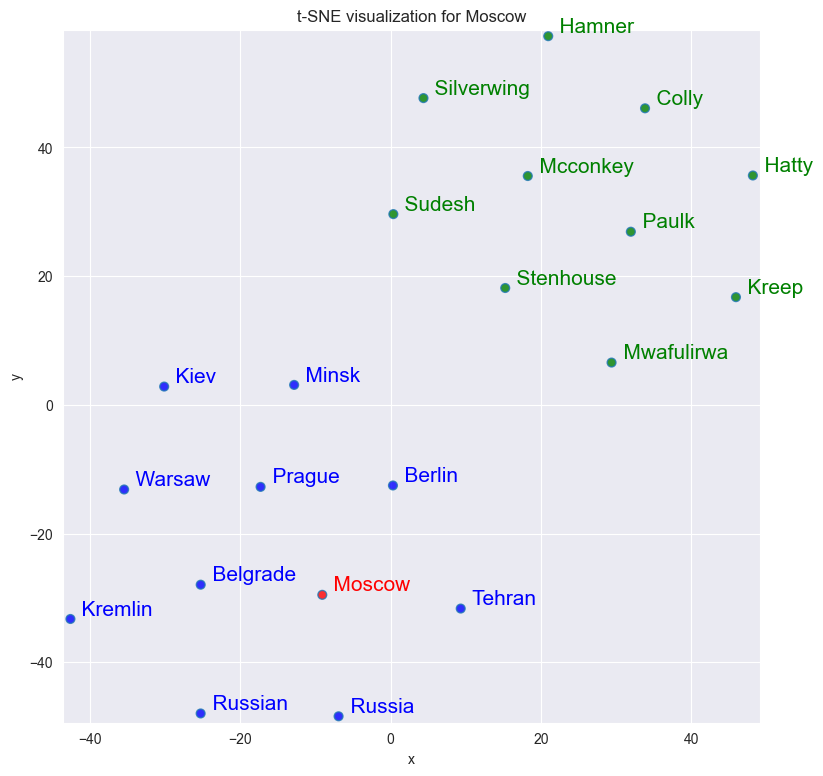

In [138]:
tsnescatterplot(model, 'moscow', [i[0] for i in w2v_model.most_similar(negative=["moscow"])])

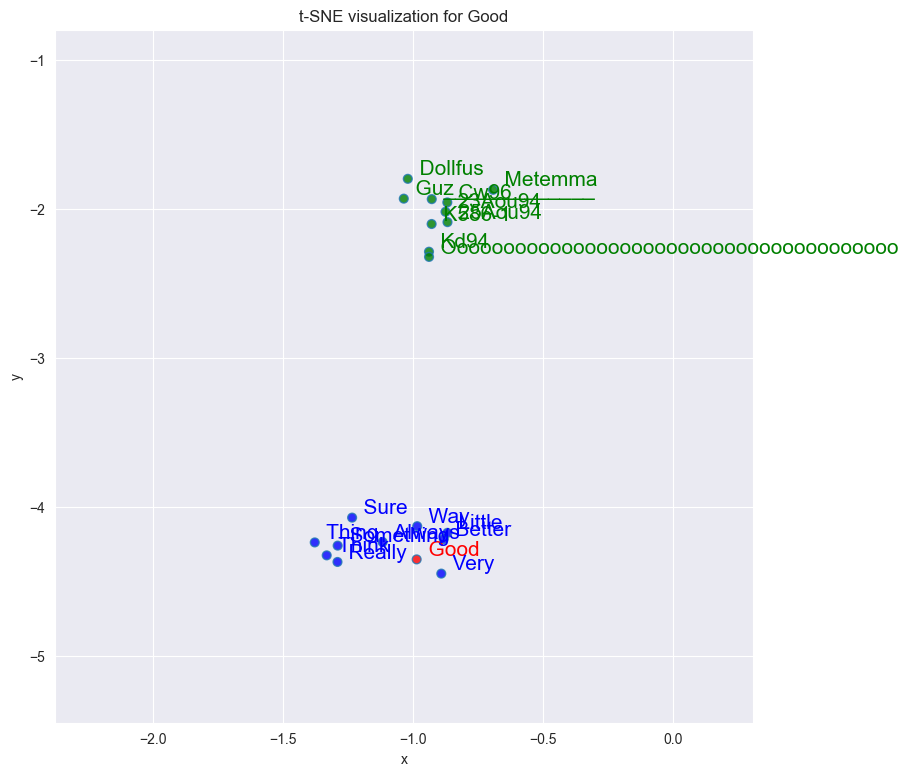

In [139]:
tsnescatterplot(model, 'good', [i[0] for i in w2v_model.most_similar(negative=["good"])])

## Compare with other pretrained embeddings

Word analogy was quite a popular method of model evaluation back in the day. [Here](https://github.com/vecto-ai/word-benchmarks/tree/master) is an example of such benchmark datasets.

- What are the problems of this approach?
- How modern models are evaluated?

In [140]:
# fasttext_model300 = api.load('fasttext-wiki-news-subwords-300')

In [141]:
# word2vec_model300 = api.load('word2vec-google-news-300')

In [142]:
#glove_model300 = api.load('glove-wiki-gigaword-300')

To define which one performs better using the respective model's evaluate_word_analogies()

Compute performance of the model on an analogy test set. The accuracy is reported for each section separately, plus there’s one aggregate summary at the end.

Input:
- ```analogies``` (str) – Path to file, where lines are 4-tuples of words, split into sections by “: SECTION NAME” lines. See [this file](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/datasets/questions-words.txt) as example.



```
: capital-common-countries
Athens Greece Baghdad Iraq
Athens Greece Bangkok Thailand
Athens Greece Beijing China
Athens Greece Berlin Germany
Athens Greece Bern Switzerland
Athens Greece Cairo Egypt
Athens Greece Canberra Australia
Athens Greece Hanoi Vietnam
Athens Greece Havana Cuba
Athens Greece Helsinki Finland
Athens Greece Islamabad Pakistan
```



Output:
- ```score``` (float) – The overall evaluation score on the entire evaluation set

- ```sections``` (list of dict of {str : str or list of tuple of (str, str, str, str)}) – Results broken down by each section of the evaluation set. Each dict contains the name of the section under the key ‘section’, and lists of correctly and incorrectly predicted 4-tuples of words under the keys ‘correct’ and ‘incorrect’.

In [143]:
wget.download("https://raw.githubusercontent.com/nicholas-leonard/word2vec/master/questions-words.txt")

'questions-words.txt'

In [144]:
f = open('questions-words.txt', 'r')
for i in range(5):
    print(f.readline())
f.close()

: capital-common-countries

Athens Greece Baghdad Iraq

Athens Greece Bangkok Thailand

Athens Greece Beijing China

Athens Greece Berlin Germany



In [145]:
# w2v_accuracy
# print(word2vec_model300.evaluate_word_analogies(analogies='questions-words.txt')[0])

# fasttext_accuracy
# print(fasttext_model300.evaluate_word_analogies(analogies='questions-words.txt')[0])

# GloVe accuracy
# print(glove_model300.evaluate_word_analogies(analogies='questions-words.txt')[0])

## Doc2Vec

Unlike Word2Vec, a [Doc2Vec](https://arxiv.org/pdf/1405.4053v2.pdf) model provides a vectorised representation of a group of words taken collectively as a single unit. It is not a simple average of the word vectors of the words in the sentence.

<div>
<img src="https://shuzhanfan.github.io/assets/images/doc2vec.jpg" width="500"/>
</div>


The training data for ```Doc2Vec``` should be a list of ```TaggedDocuments```. To create one, we pass a list of words and a unique integer as input to the ```models.doc2vec.TaggedDocument()```.

In [146]:
#prepare dataset
def create_tagged_document(list_of_list_of_words):
    for i, list_of_words in enumerate(list_of_list_of_words):
        yield TaggedDocument(list_of_words, [i])

dataset = api.load("text8")
data = [d for d in dataset]

train_data = list(create_tagged_document(data))
print(train_data[:1])

[TaggedDocument(words=['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term', 'is', 'still', 'used', 'in', 'a', 'pejorative', 'way', 'to', 'describe', 'any', 'act', 'that', 'used', 'violent', 'means', 'to', 'destroy', 'the', 'organization', 'of', 'society', 'it', 'has', 'also', 'been', 'taken', 'up', 'as', 'a', 'positive', 'label', 'by', 'self', 'defined', 'anarchists', 'the', 'word', 'anarchism', 'is', 'derived', 'from', 'the', 'greek', 'without', 'archons', 'ruler', 'chief', 'king', 'anarchism', 'as', 'a', 'political', 'philosophy', 'is', 'the', 'belief', 'that', 'rulers', 'are', 'unnecessary', 'and', 'should', 'be', 'abolished', 'although', 'there', 'are', 'differing', 'interpretations', 'of', 'what', 'this', 'means', 'anarchism', 'also', 'refers'

In [147]:
#Train model
model = Doc2Vec(vector_size=52, min_count=1, epochs=4)
model.build_vocab(train_data)
model.train(train_data, total_examples=model.corpus_count, epochs=model.epochs)

In [148]:
#Get document vector
print(model.infer_vector('gensim is really awesome'.split(' ')))

[-0.01594927 -0.0310007   0.00978712 -0.01870558 -0.01842248  0.00182286
 -0.0008619  -0.03611378  0.008618   -0.00171279 -0.0079694   0.01582212
 -0.04610793 -0.04723357 -0.00974579  0.03004041  0.03078717  0.0464299
 -0.04436761  0.00815085 -0.03354523  0.02556602 -0.0176084   0.01395943
  0.01511192 -0.06470791 -0.00613941 -0.02512796  0.02884538  0.00182717
 -0.04084625 -0.02683503 -0.00634062  0.01488102 -0.01605392 -0.00040766
  0.0045303   0.00383289  0.00316438 -0.03357029  0.01135466 -0.02842295
  0.0121868  -0.03309381  0.01651419  0.01461507  0.04013918 -0.01055094
  0.01050571 -0.03967948  0.00506622 -0.02140224]


## Word2Vec for Russian language

[RusVectores](https://rusvectores.org/ru/models/) provides a lot of different word embedding models in RusVectores.

In [149]:
import wget
import zipfile

# model -- ruscorpora_upos_cbow_300_20_2019
model_url = 'http://vectors.nlpl.eu/repository/20/180.zip'
wget.download(model_url)

'180.zip'

In [150]:
!unzip 180.zip

"unzip" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [151]:
model_ru = gensim.models.KeyedVectors.load_word2vec_format('model.bin', binary=True)

FileNotFoundError: [Errno 2] No such file or directory: 'model.bin'

In [ ]:
words = ['день_NOUN', 'ночь_NOUN', 'человек_NOUN', 'семантика_NOUN', 'биткоин_NOUN']

In [ ]:
for word in words:
    if word in model_ru:
        print(word)
        print(model_ru[word][:10])
        for word, sim in model_ru.most_similar(positive=[word], topn=10):
            print(word, ': ', sim)
        print('\n')
    else:
        print('There is no word "%s" in the model!' % word)

день_NOUN
[ 1.805067   -0.877623   -1.0102742   2.8518744  -0.43311968 -3.7207692
 -3.4317713  -0.7634762  -4.9961104  -1.1313324 ]
неделя_NOUN :  0.7375996112823486
день_PROPN :  0.706766664981842
месяц_NOUN :  0.7037326097488403
час_NOUN :  0.6643950939178467
утро_NOUN :  0.6526744961738586
вечер_NOUN :  0.6038411259651184
сутки_NOUN :  0.5923080444335938
воскресенье_NOUN :  0.5842781066894531
полдень_NOUN :  0.5743688344955444
суббота_NOUN :  0.5345946550369263


ночь_NOUN
[-0.10776415  0.32673436  0.52870405  2.1667976   0.7689093  -2.4214501
 -1.4222336  -2.972895    0.18769576 -0.05231643]
ночь_PROPN :  0.8310787081718445
вечер_NOUN :  0.7183678150177002
рассвет_NOUN :  0.6965947151184082
ночи_NOUN :  0.692021906375885
полночь_NOUN :  0.6704976558685303
ночь_VERB :  0.6615265011787415
утро_NOUN :  0.6263936161994934
ночной_ADJ :  0.6024709343910217
полдень_NOUN :  0.5835085511207581
сумерки_NOUN :  0.5671443939208984


человек_NOUN
[ 0.02881786 -0.7942778   2.4604542   2.2049303 

Used materials:
    
- https://www.machinelearningplus.com/nlp/gensim-tutorial/
- https://radimrehurek.com/gensim/models/word2vec.html
- https://radimrehurek.com/gensim/models/keyedvectors.html
- https://rare-technologies.com/word2vec-tutorial/